In [1]:
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = inputs
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

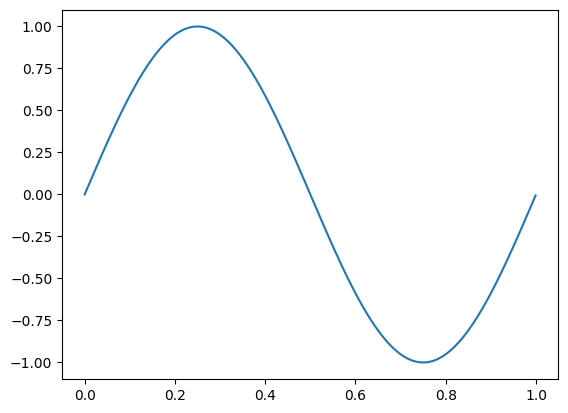

epoch: 0, acc:  0.003, loss:  0.496 (data_loss:  0.496, reg_loss:  0.000), lr: 0.005
epoch: 100, acc:  0.017, loss:  0.048 (data_loss:  0.048, reg_loss:  0.000), lr: 0.004549590536851684
epoch: 200, acc:  0.242, loss:  0.001 (data_loss:  0.001, reg_loss:  0.000), lr: 0.004170141784820684
epoch: 300, acc:  0.786, loss:  0.000 (data_loss:  0.000, reg_loss:  0.000), lr: 0.003849114703618168
epoch: 400, acc:  0.885, loss:  0.000 (data_loss:  0.000, reg_loss:  0.000), lr: 0.0035739814152966403
epoch: 500, acc:  0.082, loss:  0.000 (data_loss:  0.000, reg_loss:  0.000), lr: 0.00333555703802535
epoch: 600, acc:  0.914, loss:  0.000 (data_loss:  0.000, reg_loss:  0.000), lr: 0.0031269543464665416
epoch: 700, acc:  0.921, loss:  0.000 (data_loss:  0.000, reg_loss:  0.000), lr: 0.002942907592701589
epoch: 800, acc:  0.086, loss:  0.000 (data_loss:  0.000, reg_loss:  0.000), lr: 0.0027793218454697055
epoch: 900, acc:  0.931, loss:  0.000 (data_loss:  0.000, reg_loss:  0.000), lr: 0.00263296471827

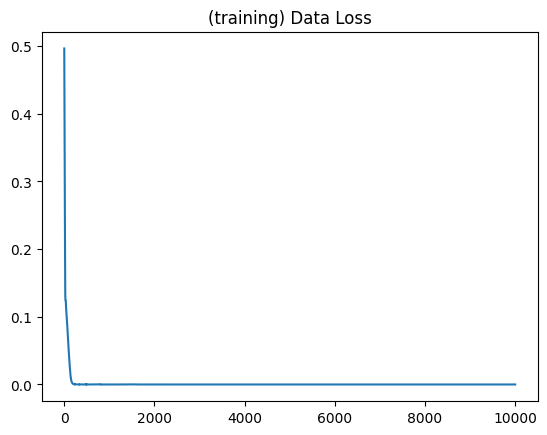

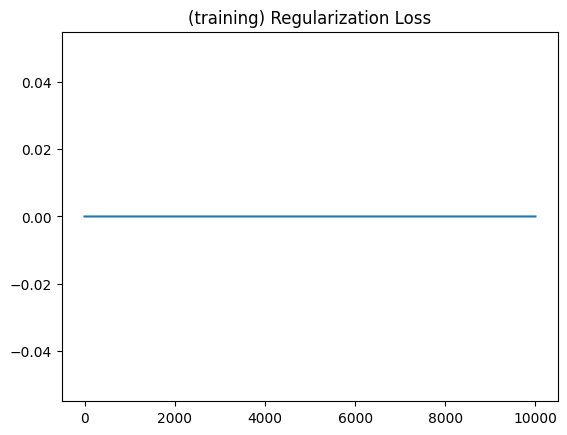

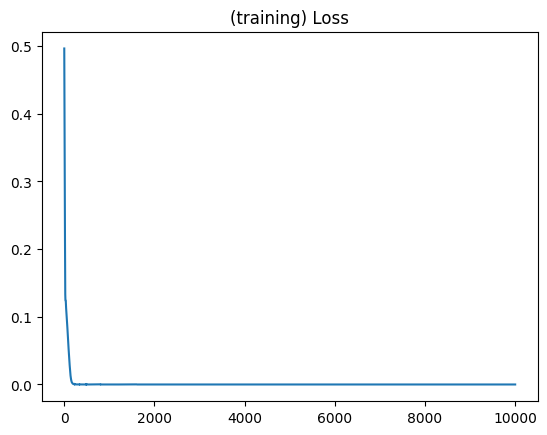

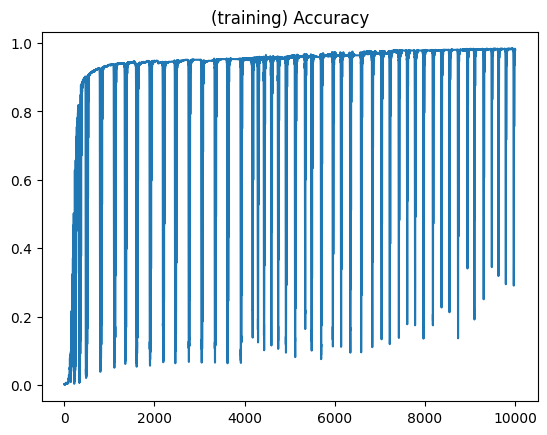

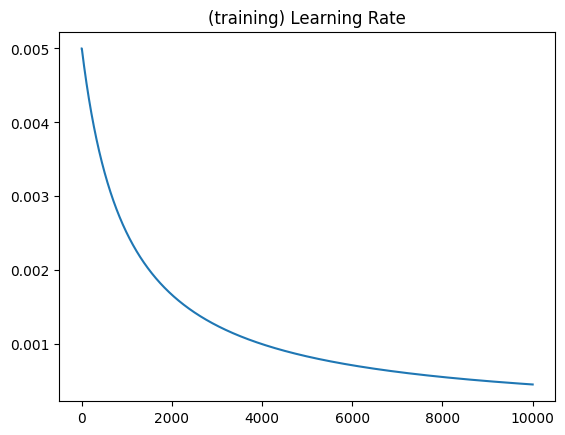

test, acc:  0.977, loss:  0.000


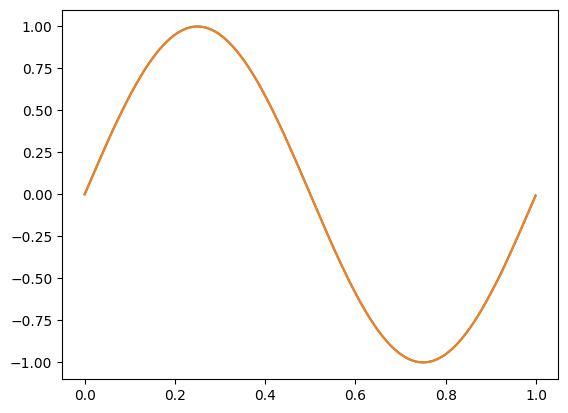

In [21]:
import numpy as np
import nnfs
from nnfs.datasets import sine_data
import matplotlib.pyplot as plt

nnfs.init()

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regluarizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regluarizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
        
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
            
        if self.bias_regularizer_l2 > 0:
            self.biases += 2 * self.bias_regularizer_l2 * self.biases
            
        self.dinputs = np.dot(dvalues, self.weights.T)
        
class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate
        
    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask
        
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs) 
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        
class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.shape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
            
class Activation_Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        
    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output
        
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        
class Optimizer_SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay 
        self.iterations = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
                
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentums * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
            
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    def post_update_params(self):
        self.iterations += 1
        
class Optimizer_Adagrad:
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.biase_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
class Optimizer_RMSprop:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
        
    def post_update_params(self):
        self.iterations += 1
        
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
        
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights) 
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases) 
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1)) 
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
class Loss:
    def regularization_loss(self, layer):
        regularization_loss = 0
        
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
            
        return regularization_loss
    
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
            
        elif len(y_true.shaoe) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
            
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        sampels = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
            
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / sampels
    
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples
        
class Loss_BinaryCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        samples_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        samples_losses = np.mean(samples_losses, axis=-1)
        return samples_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / outputs
        self.dinputs = self.dinputs / samples
        
class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples
        
class Loss_MeanAbsoluteError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples
        
X, y = sine_data()
plt.plot(X, y)
plt.show()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()
loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam(learning_rate=0.005, decay=1e-3)

data_losses = []
regularization_losses = []
losses = []
accuracies = []
learning_rates = []

accuracy_precision = np.std(y) / 250

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    data_loss = loss_function.calculate(activation3.output, y)
    data_losses.append(data_loss)
    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2) + loss_function.regularization_loss(dense3)
    regularization_losses.append(regularization_loss)
    loss = data_loss + regularization_loss
    losses.append(loss)
    
    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)
    accuracies.append(accuracy)
    
    learning_rates.append(optimizer.current_learning_rate)
    if not epoch%100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy: .3f}, ' + 
              f'loss: {loss: .3f} (' +
              f'data_loss: {data_loss: .3f}, ' +
              f'reg_loss: {regularization_loss: .3f}), ' +
              f'lr: {optimizer.current_learning_rate}')
    
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()
    
plt.plot(range(10001), data_losses)
plt.title('(training) Data Loss')
plt.show()
plt.plot(range(10001), regularization_losses)
plt.title('(training) Regularization Loss')
plt.show()
plt.plot(range(10001), losses)
plt.title('(training) Loss')
plt.show()
plt.plot(range(10001), accuracies)
plt.title('(training) Accuracy')
plt.show()
plt.plot(range(10001), learning_rates)
plt.title('(training) Learning Rate')
plt.show()

X_test, y_test = sine_data()

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
loss = loss_function.calculate(activation3.output, y_test)

predictions = activation3.output
accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)

print(f'test, acc: {accuracy: .3f}, loss: {loss: .3f}')

plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()